//Copyright (c) Microsoft Corporation. All rights reserved. 
//Licensed under the MIT License.

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import keras 
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
from scipy import stats
import tensorflow as tf
import warnings
import PrivacyGAN as pg 
from keras.models import load_model
from datetime import datetime


warnings.filterwarnings("ignore")
K.set_image_dim_ordering('th')

### Load dataset

In [2]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_test = (X_test.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
X_all = np.concatenate((X_train,X_test))


#Generate training test split
frac = 0.1 
n = int(frac*len(X_all))
l = np.array(range(len(X_all)))
l = np.random.choice(l,len(l),replace = False)
X = X_all[l[:n]]
X_comp = X_all[l[n:]]

print('training set size:',X.shape)
print('test set size:',X_comp.shape)

training set size: (7000, 784)
test set size: (63000, 784)


### Simple GAN

In [3]:
(generator, discriminator, dLosses, gLosses) = pg.SimpGAN(X, epochs = 500, batchSize = 256, verbose = 50)

Epochs: 500
Batch size: 256
Batches per epoch: 27.34375
epoch = 50/500, d_loss=0.465, g_loss=1.934                                                                                                     
epoch = 100/500, d_loss=0.478, g_loss=1.958                                                                                                     
epoch = 150/500, d_loss=0.448, g_loss=2.090                                                                                                     
epoch = 200/500, d_loss=0.419, g_loss=2.330                                                                                                     
epoch = 250/500, d_loss=0.372, g_loss=2.598                                                                                                     
epoch = 300/500, d_loss=0.342, g_loss=2.777                                                                                                     
epoch = 350/500, d_loss=0.332, g_loss=3.057                                

In [4]:
#perform white box attack
Acc = pg.WBattack(X,X_comp, discriminator)

White-box attack accuracy: 0.466


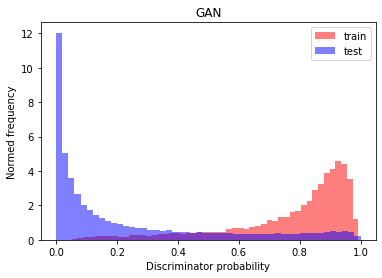

In [5]:
#plot distribution of discriminator scores of training and test set
plt.hist(discriminator.predict(X)[:,0],color = 'r', alpha = 0.5, label = 'train', normed = 1, bins = 50)
plt.hist(discriminator.predict(X_comp)[:,0],color = 'b', alpha = 0.5, label = 'test', normed = 1, bins = 50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('GAN')
plt.legend()

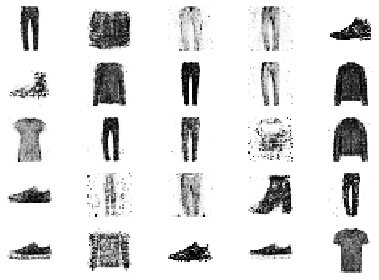

In [6]:
#Generate fake images
pg.DisplayImages(generator, figSize=(5,5), NoImages = 25)

### Private GAN 

In [7]:
K.clear_session()
optim = Adam(lr=0.0002, beta_1=0.5)
generators = [pg.MNIST_Generator(optim = Adam(lr=0.0002, beta_1=0.5)),
              pg.MNIST_Generator(optim = Adam(lr=0.0002, beta_1=0.5))]
discriminators = [pg.MNIST_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))
                  ,pg.MNIST_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))]
pDisc = pg.MNIST_DiscriminatorPrivate(OutSize = 2, 
                                      optim = Adam(lr=0.0002, beta_1=0.5))

(generators, discriminators, _, dLosses, dpLosses, gLosses)= pg.privGAN(X, epochs = 500, 
                                                                           disc_epochs=50,
                                                                           batchSize=256,
                                                                           generators = generators, 
                                                                           discriminators = discriminators,
                                                                           pDisc = pDisc,
                                                                           optim = optim,
                                                                           privacy_ratio = 1.0)

Train on 7000 samples, validate on 7000 samples
Epoch 1/50
7000/7000 [==============================] - 1s 94us/step - loss: 0.7317 - val_loss: 0.6876
Epoch 2/50
7000/7000 [==============================] - 0s 17us/step - loss: 0.6928 - val_loss: 0.6813
Epoch 3/50
7000/7000 [==============================] - 0s 17us/step - loss: 0.6865 - val_loss: 0.6849
Epoch 4/50
7000/7000 [==============================] - 0s 17us/step - loss: 0.6810 - val_loss: 0.6854
Epoch 5/50
7000/7000 [==============================] - 0s 17us/step - loss: 0.6770 - val_loss: 0.6807
Epoch 6/50
7000/7000 [==============================] - 0s 16us/step - loss: 0.6730 - val_loss: 0.6722
Epoch 7/50
7000/7000 [==============================] - 0s 16us/step - loss: 0.6646 - val_loss: 0.6483
Epoch 8/50
7000/7000 [==============================] - 0s 16us/step - loss: 0.6632 - val_loss: 0.6823
Epoch 9/50
7000/7000 [==============================] - 0s 16us/step - loss: 0.6541 - val_loss: 0.6678
Epoch 10/50
7000/7000 [==

In [8]:
#perform white box attack
pg.WBattack_priv(X,X_comp, discriminators)

White-box attack accuracy (max): 0.2671428571428571
White-box attack accuracy (mean): 0.14714285714285713


(0.2671428571428571, 0.14714285714285713)

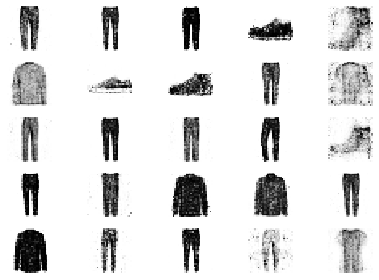

In [9]:
#Generate fake images
pg.DisplayImages(generators[1], figSize=(5,5), NoImages = 25)

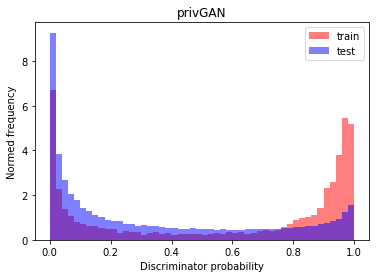

In [10]:
#plot distribution of discriminator scores of training and test set
plt.hist(discriminators[0].predict(X)[:,0],color = 'r', alpha = 0.5, label = 'train', normed = 1, bins = 50)
plt.hist(discriminators[0].predict(X_comp)[:,0],color = 'b', alpha = 0.5, label = 'test', normed = 1, bins = 50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('privGAN')
plt.legend()